# SICSS 2025: Active Learning Workshop

> Diletta Goglia, Uppsala University | <diletta.goglia@it.uu.se> | Bluesky: [@dilettagoglia.bsky.social](https://bsky.app/profile/dilettagoglia.bsky.social)
> 
> Hendrik Erz, IAS | <hendrik.erz@liu.se> | Bluesky: [@hendrik-erz.de](https://bsky.app/profile/hendrik-erz.de)
>
> Alexandra Rottenkolber, IAS | <alexandra.rottenkolber@liu.se> | Bluesky: [@alexandrartnk.bsky.social](https://bsky.app/profile/alexandrartnk.bsky.social)

Welcome to the Active Learning (AL) workshop as part of the Computational Text Analaysis day. In this notebook, you will learn how to automatically label a dataset, starting from a small set of human-labeled texts (the "gold standard" data). In particular, you will …

* … train and evaluate a RoBERTa model for multi-label text annotation 
* … finetune the model
* … predict (generate) annotations for unlabelled texts

## What is Active Learning?

Active Learning is a procedure that attempts to scale up the human ability to label a corpus of text according to some predefined research question. It is of tremendous help especially in those (today very many) cases in which the corpus is exceedingly large and using, e.g., research assistants or click-workers to do the work is unfeasible (or, in the case of click-workers, unethical). The ingredients are simple: You'll first need a coding guide that defines which labels you expect to find in the corpus, and how one can identify them; then you will need a corpus of text (obviously); and finally you need a BERT-model [(Devlin et al., 2019)](http://arxiv.org/abs/1810.04805).

Active Learning [(see, e.g., Ein-Dor et al., 2020)](https://aclanthology.org/2020.emnlp-main.638) is an often iterative process, albeit there are some variations depending on corpus quality and research question. But, essentially, it goes like this, once you have defined the labels and written the coding guide:

1. You randomly pick a subset of sentences [(or paragraphs, see Bonikowski et al. 2022)](https://doi.org/10.1177/00491241221122317) which you would like to annotate and export them to, e.g., an Excel spreadsheet. This can be as little as 200 or as many as 10,000.
2. You (and/or a few colleagues with domain-knowledge) sit down and manually annotate those. If the coding guide is good and the categories are clear, this should not take long.
3. You decide on a BERT-variant (there are some for English, some for German, some for specific groups of tasks such as detecting emotional language). A good general choice for English text is RoBERTa [(Robustly Optimized BERT, see Liu et al. 2019)](https://arxiv.org/abs/1907.11692).
4. Split your manually annotated sentences (your "gold standard" dataset) into a training and a test set. A common choice is 80% for your training data, and 20% for your test (or validation) data set.
5. Train your model on the training data (this is a process called finetuning). Measure the model performance using the validation data set and take a note of measures (usually accuracy, loss, and F1 score).
6. After this first iteration, the model is likely not able to confidently distinguish between your labels. This is especially true for multi-labelling tasks and unbalanced data. So let the model annotate the entire corpus, and pick new sentences to add to the training data set. Choose from those where the model was certain (because that tells you which sentences were "false friends" to the model) and those where the model was uncertain (as those represent edge cases). Always add randomly selected sentences to the training data as well to prevent over- or underfitting. Correct the machine-created labels for those sentences where necessary. (If all labels were already correct, you were either very lucky, or you can finish the process now.)
7. Re-train the model with the newly enhanced training data. Measure the model performance again. The metrics should have gone up by a bit. Repeat steps 6 and 7 as required to arrive at a training dataset which helps the model accurately learn the coding guide.
8. Do a final round of labelling with the corpus.

There are some variations to the procedure depending on your corpus, your labels, the research question, or the BERT variant. Sometimes (if you have an extensive gold standard set), you do not have to iterate at all. Sometimes, you need to adjust which additional sentences you pick. Experiment! The goal is to arrive at a corpus that is fully and correctly labelled.

## Corpus description

In this workbook, we will replicate one of my papers in which we performed Active Learning on a corpus [(see Lamba and Erz, 2025)](https://www.sciencedirect.com/science/article/pii/S2543925124000287). In this case, we had many expert coders and therefore an extensive training dataset. This makes it a good candidate for this workbook, since you won't have to annotate any sentences and can experience the entire process of arriving at a properly labelled corpus by only focusing on the Computational Text Analysis-part of the paper.

In this paper, we collected collected ~1200 acknowledgment sections from PhD and Master theses, resulting in a corpus with a total of ~20,000 individual sentences. Next, we and some colleagues manually annotated a random sample of 900 sentences according to the type of acknowledgement they contain (academic, moral, finantial, technical, religious, library, access to data, or other). Finally, we trained a `RoBERTa-base` model to annotate the remaining data. In this notebook, we will go through all the necessary steps required for this final phase.

If you need help, please ask during the workshop or contact us via email :) Have fun with AL!

To keep with the topic of this example: I would like to acknowledge Diletta Goglia, who has turned my code into this workbook and replicated the plots from the paper!

***

# Preliminaries

## 1. Defining the Concept

For the task of automatically annotating sentences based on certain categories (here: support for writing theses), one first has to define the concept. In this case, the work has been performed by Lamba and Erz in their paper. They came up with a set of **support labels** that we are going to use. You can see them in the next cell:

In [1]:
SUPP_LABELS = [
  "Academic",
  "Moral",
  "Tech",
  "Data",
  "Library",
  "Finance",
  "Religious",
  "Unknown"
]

Note that the specific way of setting up an Active Learning task may vary. What is important is that the classifier (see below) will output a **probability distribution** over a set amount of labels. In other words, the output of the classifier is a vector of numbers where the numbers correspond to the certainty with which the classifier believes that a given sentence is part of the given category. Assigning a label then involves taking the index of the highest value in this label, which — in our case — corresponds to the index of the label in the list of `SUPP_LABELS`.

## 2. Installing the necessary packages

This notebook makes use of a variety of Python packages, which should be installed on your machine.

Make sure to install packages according to how you have set up Python. If you use plain `pip`, here is how you can install them:

```bash
python -m pip install tqdm          # Used for progress bars
python -m pip install transformers  # To use the models
python -m pip install torch         # PyTorch for model handling
python -m pip install evaluate      # For validation metrics
python -m pip install matplotlib    # For plotting
python -m pip install seaborn       # Again, for plotting
```

## 3. Import modules

Next, we will import them.

In [2]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm 
from transformers import RobertaTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer 
import torch 
from torch import nn
import evaluate
import random
import matplotlib.pyplot as plt
import seaborn as sns

/opt/homebrew/Caskroom/miniforge/base/envs/nlpbert/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 4. Setup

This phase is the initial setup step where you define key configuration values that control how your model will behave. This phase does not involve training or loading data yet. It’s just about defining your environment and behavior.

Many ML operations (e.g., shuffling and sampling) involve randomness. Setting a random seed ensures that your code produces the same results every time you run it, which is essential for reproducibility.

In [3]:
# Set seeds for reproducible results
random.seed(1989)
np.random.seed(1989)
torch.manual_seed(1989)
torch.cuda.manual_seed_all(1989)
torch.mps.manual_seed(1989)

The next steps configure PyTorch (the machine learning framework that most LLMs
are implemented in). This configuration is not terribly important, although we
leave some explanations here for clarity.

This code essentially selects the device for running the model. Usually, because
LLMs involve many parallel floating point operations (FLOPs), they benefit from
GPUs, which support this type of calculation.

If you have a MacBook (with a Silicon chip), you have "mps" ("Metal Performance Shaders")
available. On Windows or Linux, if you have an nVidia GPU, you have CUDA available.
Otherwise, use the CPU. (CUDA is a proprietary hardware abstraction layer from nVidia,
which is why this is not available for AMD GPUs.)

The code below simply checks which of the options applies to you, and chooses the best one.

In [17]:
# When running on CPU, this somehow makes sure training times do not degrade
# see: https://discuss.pytorch.org/t/training-time-gets-slower-and-slower-on-cpu/145483/3
torch.set_flush_denormal(True)

device = torch.device("cpu") # Fallback: CPU

if torch.backends.mps.is_available():
  device = torch.device("mps")
elif torch.cuda.is_available():
  device = torch.device("cuda")

# Annotated Data Loading

Now, we load the human-annotated dataset and we create both the training and the validation datasets for our model. Then we put the data into a format that our model can understand.

To do so, we define a loading function (`read_samples`) that basically just reads the examples from disk and returns tupled with the sentence and the labels.

Please excude the somewhat weird format in which we put the data, a simpler way would've been to use the corresponding index verbatim, but initially, we wanted to allow for multiple labels.

In [5]:
sentences: list[str] = list()
labels: list[int] = list()

In [4]:
def read_samples():
  """Reads in the gold data and yields tuples (sentence, labels)"""
  with open("AL_gold_data.tsv", "r", encoding="utf-8") as fp:
    next(fp) # Skip header
    for line in fp:
      cols = line.strip().split("\t")
      sentence = cols[0]
      # Instead of having the corresponding label number, the dataset contains
      # either a 1 or a 0 for all nine available labels. This line of code simply
      # converts this into the actual label integer (0-9).
      label = np.argmax(np.asarray([int(x) for x in cols[1:9]]))
      yield (sentence, label)

In [6]:
for sentence, label in read_samples():
    sentences.append(sentence)
    labels.append(label)

At this point, we have two lists, one with sentences and one with the corresponding labels. Next, we need to actually divide the data into one training and one test (or validation) dataset. We will finetune the `RoBERTa` model on the training dataset, and test whether the model is accurate by evaluating its performance on the test data. If the performance measures are good, this indicates that the model has learned. Sometimes, you may want to add additional training examples, especially if the model performance is quite bad.

We use a pretty standard 80:20 Pareto-split (80% of the gold data for training, 20% for validation).

In [7]:
# We randomly select sentences for the training dataset...
rand = np.random.default_rng()
train_idx: list[int] = rand.choice(len(sentences), size=round(len(sentences) * 0.8), replace = False)
# ... and use all others for the validation dataset.
valid_idx = set(range(len(sentences))).difference(set(train_idx))

print(f"Datasets prepared! We are training with {len(train_idx)} training and {len(valid_idx)} validation samples.")

Datasets prepared! We are training with 722 training and 181 validation samples.


In [ ]:
# This class helps us organize inputs and labels into a format that PyTorch models understand.
# This is not necessarily required, but you can pass the data more conveniently.

class CustomDataset(torch.utils.data.Dataset):
  """Basically copied verbatim from https://huggingface.co/transformers/v3.5.1/custom_datasets.html"""
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self, idx):
    item = {key: val[idx] for key, val in self.encodings.items()}
    item['labels'] = self.labels[idx]
    return item

  def __len__(self):
    return len(self.labels)

# Prepare the Finetuning Step

Now that the data is prepared, we can prepare the model to finetune. As already indicated, we will be using `RoBERTa-base` for this task.

**Note**: We actually need two "models". One is the tokenizer, a model that splits up a text into tokens, and the model itself, which uses these tokens to make its predictions.

This step will download both models (ca. 500MB).

In [ ]:
# NOTE: This will download the roberta-base model to your machine
# To use a model from your computer, you can also pass a path to the model folder here.
model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=len(SUPP_LABELS), # How many labels should the model learn to assign?
    problem_type="single_label_classification"
  )

# NOTE: This will download the roberta-base tokenizer model to your device.
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Finally, we need a small utility function that takes either our training or validation datasets, and converts them into the dataset class. (We have to define it after we load the tokenizer, as the function depends on it.)

In [11]:
# This function converts a list of raw text sentences and their labels into a PyTorch dataset
def sentences_to_data_loader (sentences: list[str], labels: list[int]):
  """Takes a list of sentences, a batch size and a list of integer labels and constructs a dataset from that."""
  tok = tokenizer(sentences, padding="max_length", truncation=True, return_tensors='pt', return_attention_mask=True)
  return CustomDataset(tok, torch.tensor(labels))


In [12]:
# Now create our two training datasets:
support_train = sentences_to_data_loader([sentences[i] for i in train_idx], labels=[labels[i] for i in train_idx])
support_valid = sentences_to_data_loader([sentences[i] for i in valid_idx], labels=[labels[i] for i in valid_idx])

## Model Training Evaluation

During finetuning, we want to know how good our model is. Two common metrics are accuracy and F1. We define a function that the library we use for training expects. In the training step, the framework will call our function, and keep a tally of any performance metrics we return from it.

In [25]:
# How to determine the best model (ideally f1, otherwise loss works)
metric = 'f1'

# This is needed for the Training step below. Indicates to the trainer whether
# the metric should go up (F1 score) or down (loss).
is_greater_better = True

# Except for loss, we must manually calculate the metrics.
f1_metric = evaluate.load('f1')
acc_metric = evaluate.load('accuracy')

In [ ]:
def compute_metrics_support(eval_pred):
    """Takes in the predicted labels for the validation/test set, and should return a dictionary of values."""
    predictions, labels = eval_pred
    predictions = torch.from_numpy(predictions)
    predictions = nn.functional.softmax(predictions, dim=-1)
    predictions = np.argmax(predictions, axis=-1)

    # Calculates one F1 per label, so we should have an array with 8 elements
    f1 = f1_metric.compute(predictions=predictions, references=labels, average=None)['f1']
    acc = acc_metric.compute(predictions=predictions, references=labels)['accuracy']

    # NOTE: We define the F1 here as the average score of all categories
    avg_f1 = np.mean(f1)

    return { 'f1': avg_f1, 'accuracy': acc }

# Finetuning

We can finally train the RoBERTa model. The following block sets up all the training parameters, wraps everything into a Trainer class, and then trains the model on the labeled dataset. It saves the best version automatically.

In [ ]:
args = TrainingArguments(
    output_dir = "model",
    eval_strategy = "epoch", # Print results after each epoch
    save_strategy = "epoch", # If loading best model, save + eval need to match
    per_device_train_batch_size = 8, # Default is 8
    per_device_eval_batch_size = 8,
    num_train_epochs = 15.0, # default 3
    learning_rate = 5e-05, # default: 5e-05
    adam_epsilon = 1e-8, # Taken from Rubing's script
    load_best_model_at_end = True, # Default: False
    metric_for_best_model = metric,
    greater_is_better = is_greater_better
  )

trainer = Trainer(
  model = model,
  args = args,
  train_dataset = support_train,
  eval_dataset = support_valid,
  compute_metrics = compute_metrics_support
)

print("Training support category model!")
trainer.train()
trainer.save_model("finetuned_model")
print("Model trained!")


Training support category model!


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,No log,1.132641,0.242367,0.629834
2,No log,1.121822,0.374084,0.651934
3,No log,0.992274,0.560472,0.707182
4,No log,1.099223,0.566890,0.685083
5,No log,1.678684,0.546192,0.629834
6,0.727600,1.511688,0.653949,0.701657
7,0.727600,1.554727,0.635368,0.707182
8,0.727600,1.618545,0.709582,0.734807
9,0.727600,1.803691,0.718746,0.723757
10,0.727600,1.821729,0.724773,0.734807


Model trained!


# Predictions

We are ready to annotate the rest of the texts. We first load the fine-tuned model from the folder where we saved it after training.
This restores all the learned weights so we can use the model for making predictions.

As a cool side effect, since a few years loading a model in a notebook will output its architecture (the various layers) below!

In [18]:
model = AutoModelForSequenceClassification.from_pretrained("finetuned_model")
# Note this line: This "moves" the weights from your computer's memory to your graphics card.
# (If you're on CPU, it doesn't do anything, so it's always good to keep it.)
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

## Annotating

We load the corpus that we want to annotate, and we predicts labels for each sentence using our fine-tuned model. We write the results to a file (*AL_predictions.tsv*).

In [19]:
corpus = pd.read_csv("AL_corpus.tsv", sep="\t")
print(f"Corpus size: {len(corpus)} sentences.")

Corpus size: 20170 sentences.


In [20]:
corpus # View the corpus

,year,sentence
0,1927,"Thanks are due to Dr* W. S. Pord, Assistant Pr..."
1,1927,Mr.V.
2,1927,"C. Kersey, Assistant Superintendent of Schools..."
3,1927,School principals have been very kind to allow...
4,1927,"Records of attendance, enrollment, etc were wi..."
...,...,...
20165,2020,I also acknowledge my students and colleagues ...
20166,2020,I offer a special acknowledgment to my dear fr...
20167,2020,The friendship of so many people has helped ma...
20168,2020,"responded to the survey, interest in service e..."


In [ ]:
with open("AL_predictions.tsv", "w") as fp:
  fp.write(f"year\tsentence\tsupport_label\n")
  for row in tqdm(corpus.itertuples(), total=len(corpus), desc="Predicting", dynamic_ncols=True):
    # This is what the model now needs to do: Turn the sentence into tokens, predict a label for it, and this is what we use.
    tok = tokenizer(row.sentence, padding = "max_length", truncation = True, return_tensors = 'pt')
    tok = tok.to(device)

    output = model(**tok)
    # The various functions after "output" essentially take the predictions from your device (which may be the GPU) into your computer's memory.
    predictions = output.logits.detach().squeeze(0).cpu().numpy()
    # Remember that the model spits out a vector of probabilities, with the "argmax" corresponding to the label we take.
    supp_label = np.argmax(predictions)

    fp.write(f"{row.year}\t{row.sentence}\t{SUPP_LABELS[supp_label]}\n")
    fp.flush() # Make sure we can watch as the file fills

  print("Prediction done! You can find the predictions in the ''AL_predictions.tsv'' file.")

python(70958) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Predicting:  43%|████▎     | 8759/20170 [05:22<07:00, 27.16it/s]


ValueError: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

## Visualizing the result

In [26]:
# read AL_predictions.tsv as pandas DataFrame
predictions_df = pd.read_csv("AL_predictions.tsv", sep = "\t", encoding = "utf-8")
predictions_df.head(10)

,year,sentence,support_label
0,1927,"Thanks are due to Dr* W. S. Pord, Assistant Pr...",Academic
1,1927,Mr.V.,Unknown
2,1927,"C. Kersey, Assistant Superintendent of Schools...",Data
3,1927,School principals have been very kind to allow...,Library
4,1927,"Records of attendance, enrollment, etc were wi...",Unknown
5,1927,Librarians have been willing and interested in...,Library
6,1927,"Miss Mary Ramona Bean, Publicity Director of t...",Data
7,1929,This study vaa conducted under the supervision...,Academic
8,1929,Douglas Naples as part of a more extensive in­...,Tech
9,1929,ii,Unknown


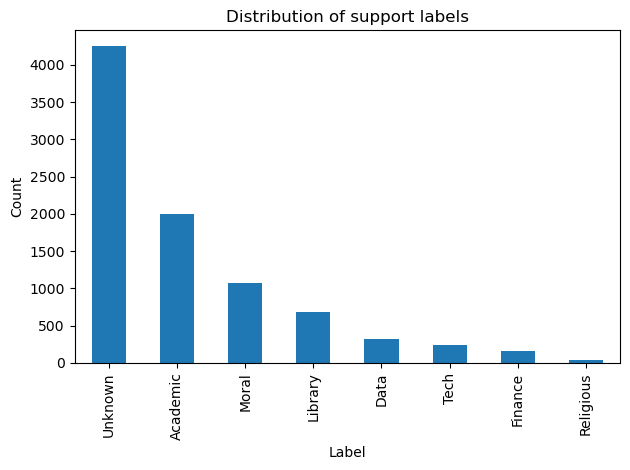

In [ ]:
# we now plot the distribution of support labels
predictions_df['support_label'].value_counts().plot(kind = 'bar')

plt.title("Distribution of support labels")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()

**What can you observe?** Are some categories much more common than others? Does anything look surprising?

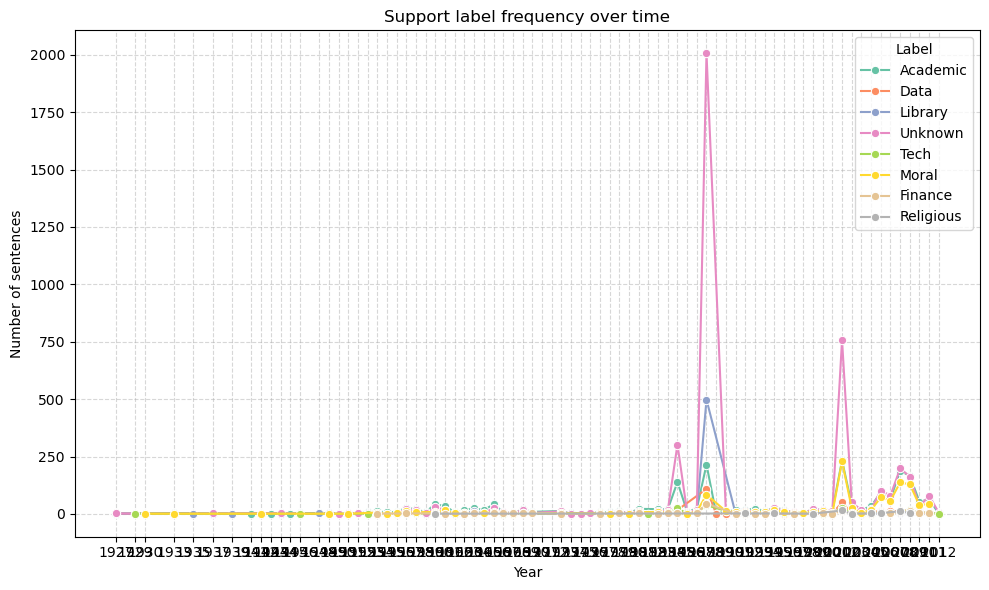

In [ ]:
counts = predictions_df.groupby(["year", "support_label"]).size().reset_index(name = "count")

# Line plot of support label frequency over time
plt.figure(figsize = (10, 6))
sns.lineplot(data = counts, x = "year", y = "count", hue = "support_label", marker = "o", palette = "Set2")

plt.title("Support label frequency over time")
plt.xlabel("Year")
plt.ylabel("Number of sentences")
plt.grid(True, linestyle = "--", alpha = 0.5)
plt.xticks(sorted(predictions_df["year"].unique()))
plt.tight_layout()
plt.legend(title="Label")

What can you observe from this temporal perspective?
Do certain categories appear more in earlier or later years? Are there any noticeable shifts, spikes, or disappearances over time?

## Extra: Handling authentication with the Hugging Face Hub 

Hugging Face is a company and open-source community that provides tools, models, and libraries for working with machine learning—especially NLP and LLMs.

To use Hugging Face’s models (especially large ones or those requiring authentication), you need an access token. This token links your Hugging Face account to your code securely.

**How to Create a Hugging Face Access Token:**

* Create a [Hugging Face account](https://huggingface.co) (if you don't already have one).
* After logging in, go to your Access Tokens page and click on "new token".
* Choose a name (e.g., sicss-token), select the role, and click "create".
* Copy the token and past it in the cell below.
* **Never share your token publicly!**

In [ ]:
from huggingface_hub import login
my_token = "PAST YOUR TOKEN HERE"
login(token=my_token)

# Conclusion

Thank you for following along with this workshop!

If you have further questions regarding the code or Active Learning do not hesitate to contact us: <diletta.goglia@it.uu.se> | @dilettagoglia on social media and <hendrik.erz@liu.se> | @hendrik-erz.de on Bluesky.

Special thanks again for Diletta for creating this notebook!